# Análise Preditiva de Inadimplência
---
Desafio proposto pela }`Datarisk`.<br>
__Candidata__: Laryssa Stephanie Andrade da Costa Silva | [LinkedIn](https://www.linkedin.com/in/laryssastephanie/) | [Github](https://github.com/laryssastephanie)

---

In [1]:
#importando Bibliotecas Necessárias

import pickle
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import lightgbm as lgb
import xgboost as xgb
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklego.meta import Thresholder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, PrecisionRecallDisplay, precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix

In [2]:
data_train = pd.read_csv('../case_datarisk/treino.csv')
data_train.index = data_train.index + 1
data_train.index.rename('cliente', inplace=True)
data_train.reset_index(level=0, inplace=True)

data_val = pd.read_csv('../case_datarisk/teste.csv')
data_val.index = data_val.index + 1
data_val.index.rename('cliente', inplace=True)
data_val.reset_index(level=0, inplace=True)

In [3]:
print(f"Treino shape {data_train.shape}")
print(f"Teste shape {data_val.shape}")

Treino shape (110000, 12)
Teste shape (40000, 11)


In [4]:
data_train['inadimplente'].value_counts()

0    102669
1      7331
Name: inadimplente, dtype: int64

In [5]:
data_train.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
cliente,110000.0,55000.50,31754.41,1.0,27500.75,55000.50,82500.25,110000.0
inadimplente,110000.0,0.07,0.25,0.0,0.00,0.00,0.00,1.0
util_linhas_inseguras,110000.0,5.93,252.30,0.0,0.03,0.16,0.56,50708.0
idade,110000.0,52.26,14.77,0.0,41.00,52.00,63.00,109.0
vezes_passou_de_30_59_dias,110000.0,0.42,4.24,0.0,0.00,0.00,0.00,98.0
razao_debito,110000.0,354.82,2074.14,0.0,0.18,0.37,0.87,329664.0
salario_mensal,88237.0,6637.41,13383.95,0.0,3400.00,5400.00,8225.00,3008750.0
numero_linhas_crdto_aberto,110000.0,8.45,5.14,0.0,5.00,8.00,11.00,58.0
numero_vezes_passou_90_dias,110000.0,0.27,4.22,0.0,0.00,0.00,0.00,98.0
numero_emprestimos_imobiliarios,110000.0,1.02,1.14,0.0,0.00,1.00,2.00,54.0


In [6]:
# print de informações
qtd_total_train = data_train.shape[0]
inadimplentes_train = sum(data_train['inadimplente'])
adimplentes_train = qtd_total_train - inadimplentes_train

print("Treino:")
print(f"{inadimplentes_train} usuarios inadimplentes -> {inadimplentes_train/qtd_total_train * 100:3.2f}% dos dados totais")
print(f"{adimplentes_train} usuarios adimplentes -> {adimplentes_train/qtd_total_train * 100:3.2f}% dos dados totais\n")

Treino:
7331 usuarios inadimplentes -> 6.66% dos dados totais
102669 usuarios adimplentes -> 93.34% dos dados totais



---
## Tratando os NaN's
---

Para dados de Treino

In [7]:
data_train.isna().sum()

cliente                                      0
inadimplente                                 0
util_linhas_inseguras                        0
idade                                        0
vezes_passou_de_30_59_dias                   0
razao_debito                                 0
salario_mensal                           21763
numero_linhas_crdto_aberto                   0
numero_vezes_passou_90_dias                  0
numero_emprestimos_imobiliarios              0
numero_de_vezes_que_passou_60_89_dias        0
numero_de_dependentes                     2878
dtype: int64

In [8]:
# Assumindo que o número de dependentes em branco é zero.
data_train['numero_de_dependentes'] = data_train['numero_de_dependentes'].fillna(0)

In [9]:
data_train['salario_mensal'].describe().round(2)

count      88237.00
mean        6637.41
std        13383.95
min            0.00
25%         3400.00
50%         5400.00
75%         8225.00
max      3008750.00
Name: salario_mensal, dtype: float64

In [10]:
# Utilizando o KNNImputer para preencher os dados de salário faltantes.
imputer = KNNImputer(n_neighbors=3)
data_train_knn = pd.DataFrame(imputer.fit_transform(data_train), columns=data_train.columns)

In [11]:
data_train['salario_mensal'] = data_train_knn['salario_mensal']

In [12]:
data_train.isna().sum()

cliente                                  0
inadimplente                             0
util_linhas_inseguras                    0
idade                                    0
vezes_passou_de_30_59_dias               0
razao_debito                             0
salario_mensal                           0
numero_linhas_crdto_aberto               0
numero_vezes_passou_90_dias              0
numero_emprestimos_imobiliarios          0
numero_de_vezes_que_passou_60_89_dias    0
numero_de_dependentes                    0
dtype: int64

---
Para dados de teste

In [13]:
# Assumindo que o número de dependentes em branco é zero.
data_val['numero_de_dependentes'] = data_val['numero_de_dependentes'].fillna(0)

In [14]:
# Utilizando o KNNImputer para preencher os dados de salário faltantes.
imputer = KNNImputer(n_neighbors=3)
data_val_knn = pd.DataFrame(imputer.fit_transform(data_val), columns=data_val.columns)

In [15]:
data_val['salario_mensal'] = data_val_knn['salario_mensal']

In [16]:
data_val.isna().sum()

cliente                                  0
util_linhas_inseguras                    0
idade                                    0
vezes_passou_de_30_59_dias               0
razao_debito                             0
salario_mensal                           0
numero_linhas_crdto_aberto               0
numero_vezes_passou_90_dias              0
numero_emprestimos_imobiliarios          0
numero_de_vezes_que_passou_60_89_dias    0
numero_de_dependentes                    0
dtype: int64

## Análises de features pré-treino

Plotando gráficos de barra e box para cada feature. Para features com grande variação de dados, plotaremos apenas boxplot. 

---

In [17]:
# função para agilizar o plot em barras

def plot_bar (df, feature):
    df_aux = df.groupby([feature, 'inadimplente']).agg(n=('cliente', 'count')).unstack().droplevel(level=0, axis=1)

    fig, ax = plt.subplots(figsize=(20,5))
    ax.bar(x=df_aux.index, height=df_aux[0], log=True, color='#2984E0')
    ax.bar(x=df_aux.index, height=df_aux[1], log=True, color='#FF6C00')

    ax.legend(['Adimplente', 'Inadimplente'])
    ax.grid(axis='y', color='k', linestyle=':')
    plt.show()

In [18]:
# função para agilizar o plot de box-and-whiskers

def plot_box (df, feature, logscale=True):
    data = [df.query('inadimplente == 0')[feature], df.query('inadimplente == 1')[feature]]

    fig, ax = plt.subplots(figsize=(15,5))
    if logscale:
        ax.set_yscale('symlog', linthresh=1)
    ax.boxplot(data, labels=['Adimplente', 'Inadimplente'])
    ax.grid(axis='y', linestyle=':')
    plt.show()

1. Inadimplente
---

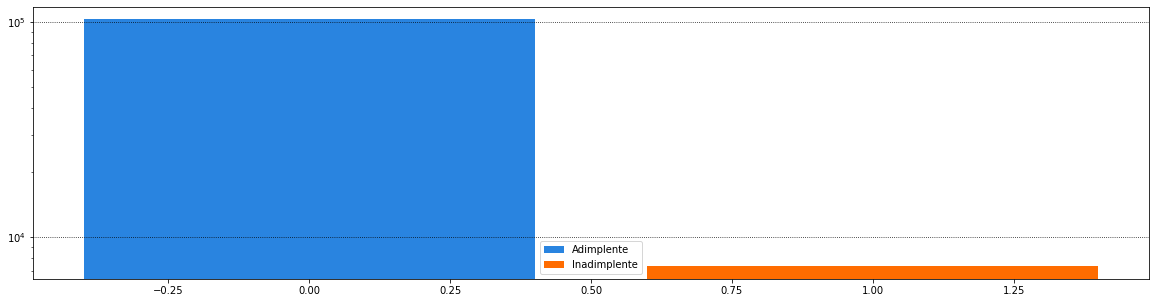

In [19]:
plot_bar(data_train, 'inadimplente')

2. util_linhas_inseguras
---

In [20]:
data_train.util_linhas_inseguras.value_counts()

0.000000    7983
1.000000    7585
1.000000      12
0.850299       5
0.954092       5
            ... 
0.156209       1
0.045194       1
0.122282       1
0.528319       1
0.037699       1
Name: util_linhas_inseguras, Length: 92671, dtype: int64

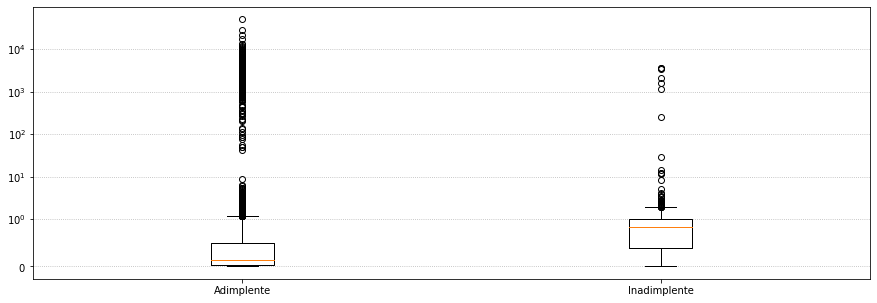

In [21]:
plot_box(data_train, 'util_linhas_inseguras')

3. idade
---

In [22]:
data_train.idade.value_counts()

48     2794
49     2788
46     2759
47     2718
50     2709
       ... 
103       2
107       1
105       1
0         1
109       1
Name: idade, Length: 86, dtype: int64

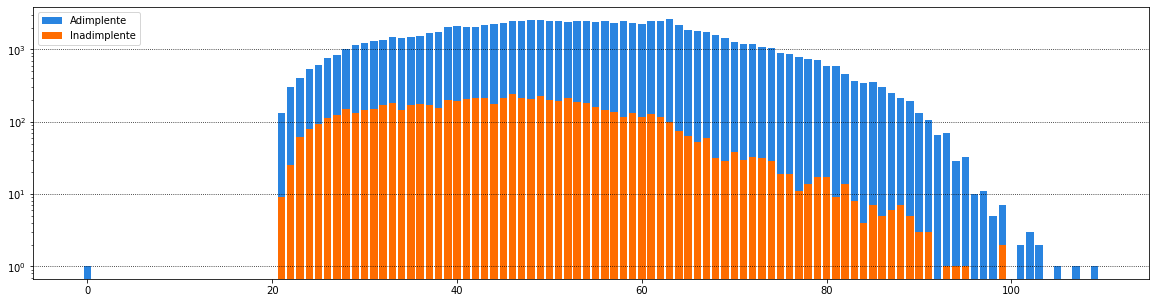

In [23]:
plot_bar(data_train, 'idade')

3. vezes_passou_de_30_59_dias
---

In [24]:
data_train.vezes_passou_de_30_59_dias.value_counts()

0     92469
1     11726
2      3343
3      1304
4       541
5       246
98      198
6        98
7        41
8        17
9         8
96        4
10        2
12        2
13        1
Name: vezes_passou_de_30_59_dias, dtype: int64

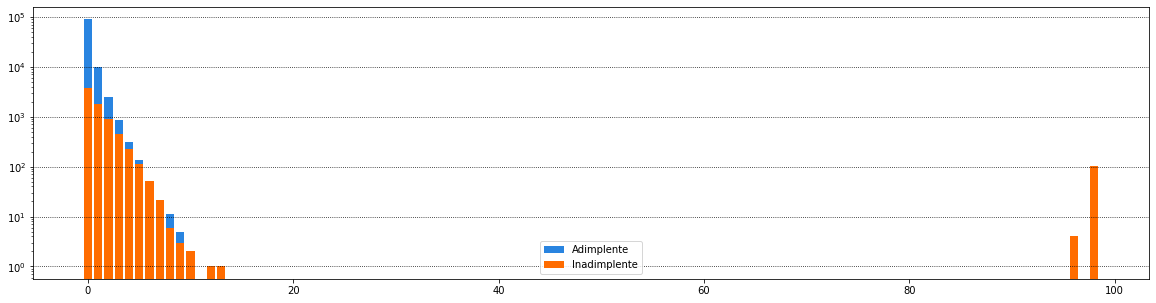

In [25]:
plot_bar(data_train, 'vezes_passou_de_30_59_dias')

4. razao_debito
---

In [26]:
data_train.razao_debito.value_counts()

0.000000    3030
1.000000     171
3.000000     130
4.000000     124
2.000000     114
            ... 
0.307381       1
0.460192       1
0.731127       1
0.310922       1
0.002352       1
Name: razao_debito, Length: 86002, dtype: int64

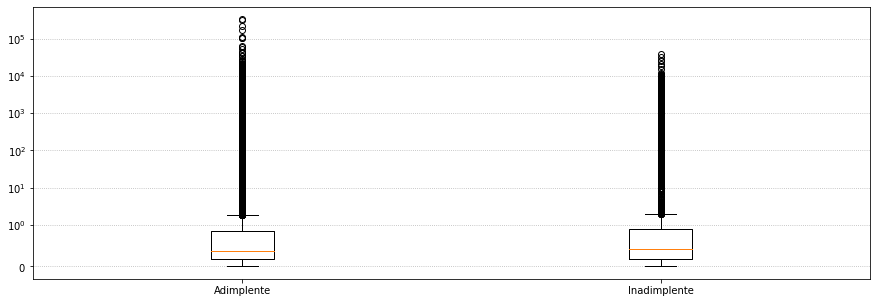

In [27]:
plot_box(data_train, 'razao_debito')

5. salario_mensal
---

In [28]:
data_train.salario_mensal.value_counts()

0.000000        8404
0.333333        5192
0.666667        2081
5000.000000     2038
4000.000000     1608
                ... 
6468.666667        1
14226.000000       1
16035.000000       1
394.000000         1
12224.000000       1
Name: salario_mensal, Length: 16136, dtype: int64

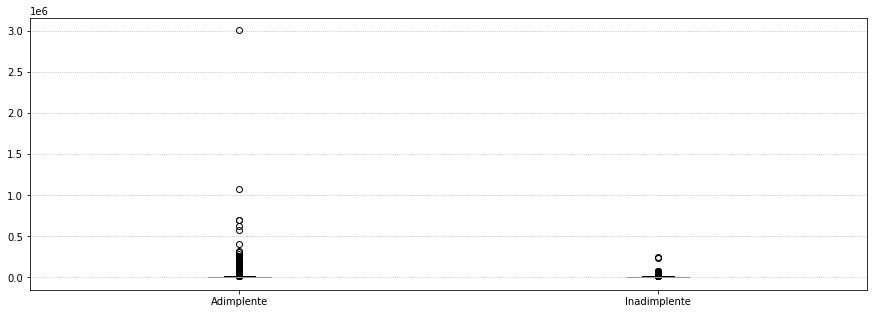

In [29]:
plot_box(data_train, 'salario_mensal', logscale=False)

6. numero_linhas_crdto_aberto
---

In [30]:
data_train.numero_linhas_crdto_aberto.value_counts()

6     9988
7     9675
5     9521
8     9171
4     8512
9     8240
10    7095
3     6652
11    6107
12    5122
2     4915
13    4163
14    3373
1     3252
15    2661
16    2173
17    1738
18    1428
0     1419
19    1037
20     847
21     649
22     522
23     394
24     313
25     221
26     164
27     138
28     111
29      91
30      62
31      58
32      37
33      31
34      21
36      17
35      13
38      11
40       8
37       5
45       5
48       5
54       4
43       4
42       4
39       3
46       3
41       3
56       2
49       2
52       2
51       2
44       2
58       1
57       1
47       1
50       1
Name: numero_linhas_crdto_aberto, dtype: int64

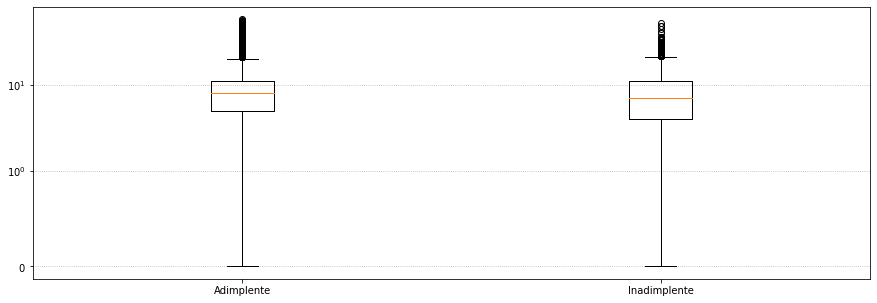

In [31]:
plot_box(data_train, 'numero_linhas_crdto_aberto')

7. numero_vezes_passou_90_dias
---

In [32]:
data_train.numero_vezes_passou_90_dias.value_counts()

0     103836
1       3886
2       1160
3        486
4        204
98       198
5        103
6         58
7         21
8         16
9         15
10         6
96         4
11         2
13         2
15         1
14         1
17         1
Name: numero_vezes_passou_90_dias, dtype: int64

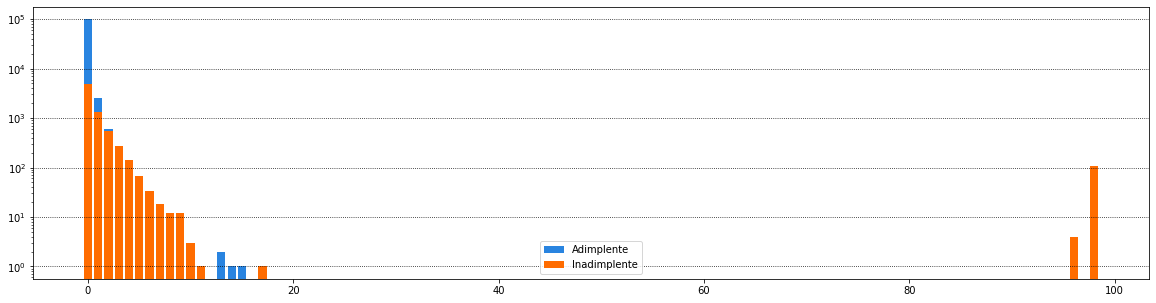

In [33]:
plot_bar(data_train, 'numero_vezes_passou_90_dias')

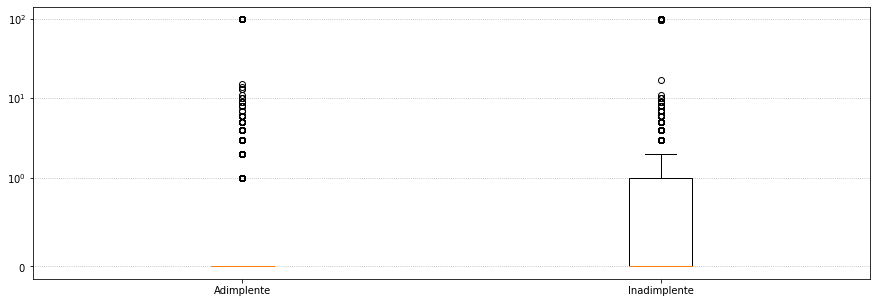

In [34]:
plot_box(data_train, 'numero_vezes_passou_90_dias')

8. numero_emprestimos_imobiliarios
---

In [35]:
data_train.numero_emprestimos_imobiliarios.value_counts()

0     41159
1     38354
2     23161
3      4644
4      1601
5       496
6       237
7       126
8        67
9        58
10       29
11       15
13       13
12       10
14        6
15        5
17        4
16        3
23        2
25        2
26        1
54        1
21        1
18        1
29        1
19        1
20        1
32        1
Name: numero_emprestimos_imobiliarios, dtype: int64

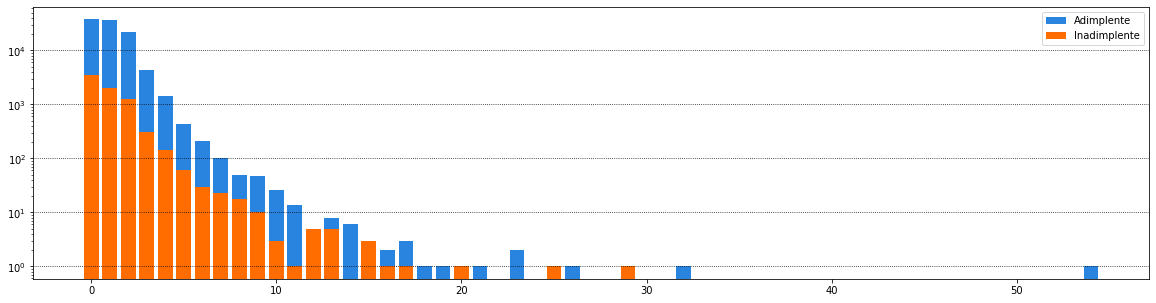

In [36]:
plot_bar(data_train, 'numero_emprestimos_imobiliarios')

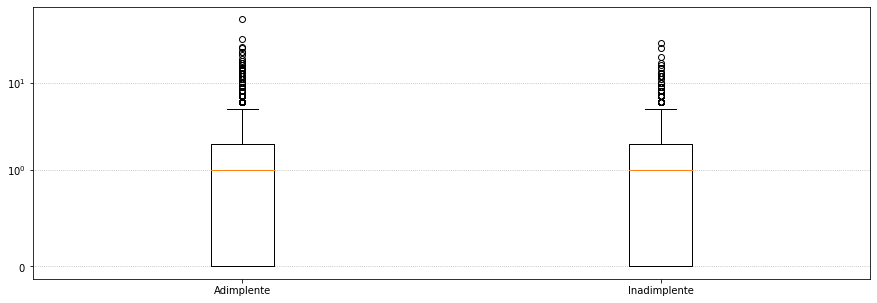

In [37]:
plot_box(data_train, 'numero_emprestimos_imobiliarios')

9. numero_de_vezes_que_passou_60_89_dias
---

In [38]:
data_train.numero_de_vezes_que_passou_60_89_dias.value_counts()

0     104466
1       4169
2        825
3        222
98       198
4         67
5         26
6         12
7          7
96         4
8          2
11         1
9          1
Name: numero_de_vezes_que_passou_60_89_dias, dtype: int64

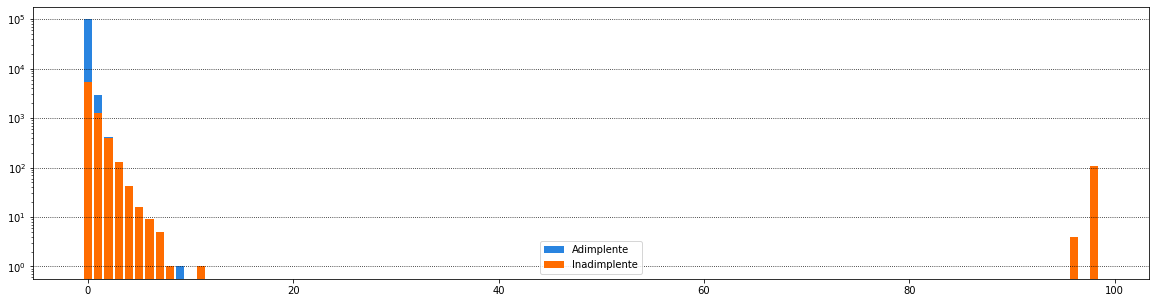

In [39]:
plot_bar(data_train, 'numero_de_vezes_que_passou_60_89_dias')

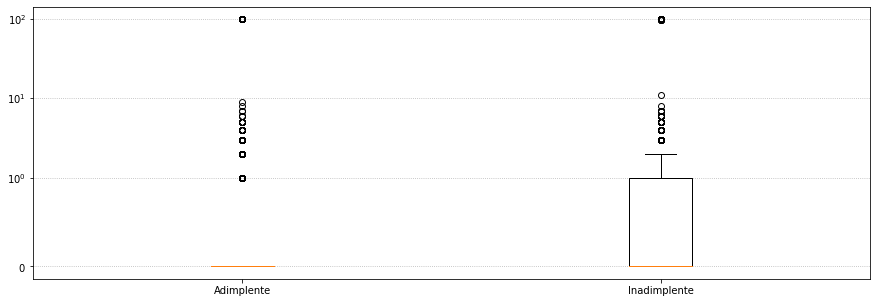

In [40]:
plot_box(data_train, 'numero_de_vezes_que_passou_60_89_dias')

10. numero_de_dependentes
---

In [41]:
data_train.numero_de_dependentes.value_counts()

0.0     66530
1.0     19416
2.0     14306
3.0      6898
4.0      2111
5.0       563
6.0       115
7.0        38
8.0        16
10.0        4
9.0         2
20.0        1
Name: numero_de_dependentes, dtype: int64

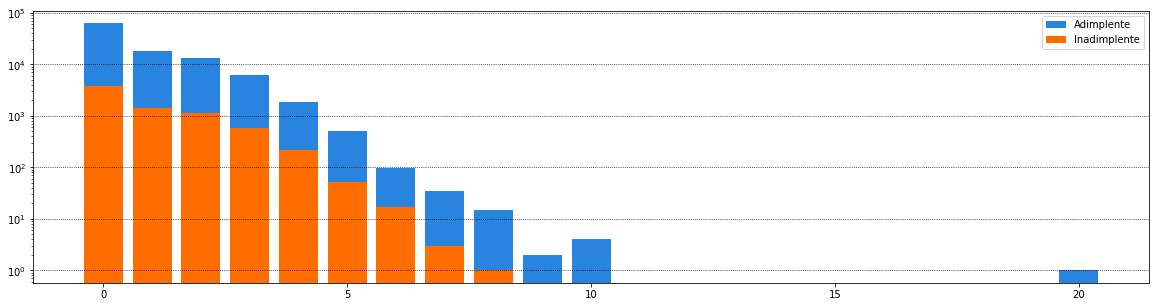

In [42]:
plot_bar(data_train, 'numero_de_dependentes')

---
## Matriz de Correlação
---

In [43]:
corr_matrix = data_train.corr()
corr_matrix

,cliente,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
cliente,1.000000,0.001944,0.002623,0.002049,0.000015,-0.002968,0.002158,0.005613,-0.000349,0.002563,-0.000087,-0.000388
inadimplente,0.001944,1.000000,-0.003263,-0.114281,0.124546,-0.006534,-0.015905,-0.029332,0.116023,-0.008144,0.101536,0.043913
util_linhas_inseguras,0.002623,-0.003263,1.000000,-0.004444,-0.001336,0.001255,0.009390,-0.010120,-0.001154,0.007590,-0.001105,-0.001467
idade,0.002049,-0.114281,-0.004444,1.000000,-0.063230,0.025221,0.022511,0.148640,-0.061371,0.032920,-0.057604,-0.214781
vezes_passou_de_30_59_dias,0.000015,0.124546,-0.001336,-0.063230,1.000000,-0.006860,-0.006923,-0.056347,0.984157,-0.031093,0.987377,-0.005225
razao_debito,-0.002968,-0.006534,0.001255,0.025221,-0.006860,1.000000,-0.077937,0.047158,-0.008344,0.117054,-0.007558,-0.045567
salario_mensal,0.002158,-0.015905,0.009390,0.022511,-0.006923,-0.077937,1.000000,0.089603,-0.009429,0.109698,-0.008452,0.089677
numero_linhas_crdto_aberto,0.005613,-0.029332,-0.010120,0.148640,-0.056347,0.047158,0.089603,1.000000,-0.080873,0.433337,-0.071979,0.074057
numero_vezes_passou_90_dias,-0.000349,0.116023,-0.001154,-0.061371,0.984157,-0.008344,-0.009429,-0.080873,1.000000,-0.045902,0.993162,-0.012903
numero_emprestimos_imobiliarios,0.002563,-0.008144,0.007590,0.032920,-0.031093,0.117054,0.109698,0.433337,-0.045902,1.000000,-0.039987,0.127292


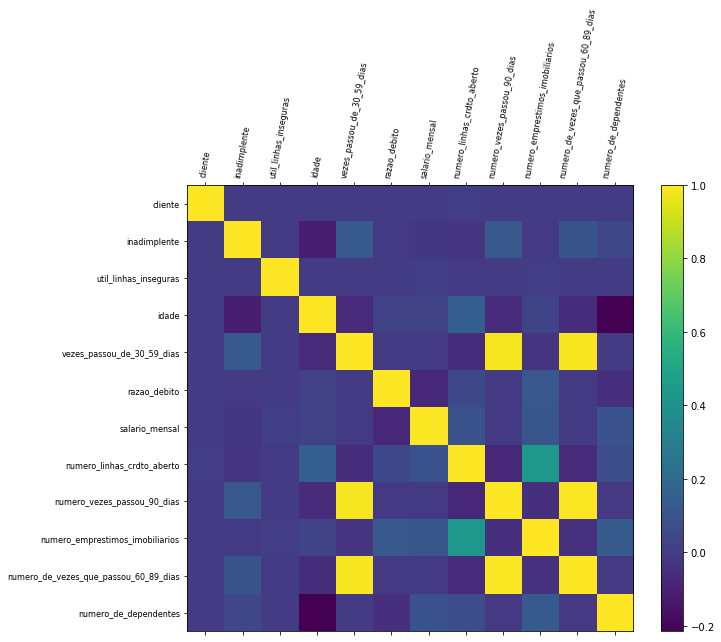

In [44]:
# melhor visualização
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_matrix, fignum=f.number)
plt.xticks(range(data_train.shape[1]), data_train.columns, fontsize=8, rotation=80)
plt.yticks(range(data_train.shape[1]), data_train.columns, fontsize=8)
colorbar = plt.colorbar()
plt.show()

In [45]:
# verifica se há colunas com valor de correlação maior do que 0.8 em módulo
corr_aux = ((data_train.corr() > abs(0.8)) & (data_train.corr() != 1)).sum()

corr_aux[corr_aux > 0]

vezes_passou_de_30_59_dias               2
numero_vezes_passou_90_dias              2
numero_de_vezes_que_passou_60_89_dias    2
dtype: int64

In [46]:
# retorna as colunas e suas respectivas correlações em relação à coluna de entrada
def return_high_corr (feature):
    return corr_matrix.loc[feature][corr_matrix.loc[feature] > abs(0.8)]

In [47]:
return_high_corr('vezes_passou_de_30_59_dias')

vezes_passou_de_30_59_dias               1.000000
numero_vezes_passou_90_dias              0.984157
numero_de_vezes_que_passou_60_89_dias    0.987377
Name: vezes_passou_de_30_59_dias, dtype: float64

In [48]:
return_high_corr('numero_vezes_passou_90_dias')

vezes_passou_de_30_59_dias               0.984157
numero_vezes_passou_90_dias              1.000000
numero_de_vezes_que_passou_60_89_dias    0.993162
Name: numero_vezes_passou_90_dias, dtype: float64

In [49]:
return_high_corr('numero_de_vezes_que_passou_60_89_dias')

vezes_passou_de_30_59_dias               0.987377
numero_vezes_passou_90_dias              0.993162
numero_de_vezes_que_passou_60_89_dias    1.000000
Name: numero_de_vezes_que_passou_60_89_dias, dtype: float64

#### Sugestão de remoção devido à alta correlação:

In [50]:
drop_features = []
drop_features.extend(['numero_de_vezes_que_passou_60_89_dias', 'numero_vezes_passou_90_dias'])

In [51]:
# remove as colunas com alta correlação, conforme acima
data_train = data_train.drop(columns=drop_features)
data_val = data_val.drop(columns=drop_features)

---
## Separando em Treino e Teste
---

In [52]:
X = data_train.drop(columns='inadimplente')

In [53]:
# Separando data_train em treino e teste
y = data_train['inadimplente']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

---
## Testando Modelos
---

In [55]:
random_state = 42

In [56]:
# primeiros modelos a serem analisados
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=random_state),
    "Random Forest": RandomForestClassifier(random_state=random_state),
    "Xgboost": xgb.XGBClassifier(random_state=random_state, use_label_encoder=False),
    "Lightgbm": lgb.LGBMClassifier(random_state=random_state)
}

# métricas que serão avaliadas
scores = {
    "recall": "recall",
    "precision": "precision",
    "f1": "f1",
    "accuracy": "balanced_accuracy",
}

In [57]:
# resultado das métricas, para cada modelo
dic_metrics = {}

for model_name, model in models.items():
    clf = model
    if model_name == 'Xgboost':
        clf.fit(X_train, y_train, eval_metric='logloss')
    else:
        clf.fit(X_train, y_train)
    resultados = cross_validate(model, X_train, y_train, scoring=scores, cv=5)
    dic_metrics[model_name] = resultados

[13:05:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:05:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:06:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:06:07] WARNING: /home

In [58]:
# mostra as métricas em um dataframe
pd.set_option('display.max_columns', None)
metrics = pd.DataFrame.from_dict(dic_metrics, orient="index").stack().to_frame()
metrics = pd.DataFrame(metrics[0].values.tolist(), index=metrics.index)
metrics['Media'] = metrics.mean(axis=1)
metrics['Desvio'] = metrics.std(axis=1)
metrics = metrics.transpose()
metrics

Decision Tree                                                  \
            fit_time score_time test_recall test_precision   test_f1   
0           0.510499   0.016633    0.246589       0.217916  0.231367   
1           0.437166   0.016030    0.225146       0.196931  0.210095   
2           0.470155   0.016496    0.216374       0.198569  0.207090   
3           0.442597   0.015564    0.246349       0.218858  0.231791   
4           0.438604   0.017018    0.219085       0.200535  0.209400   
Media       0.459804   0.016348    0.230708       0.206562  0.217949   
Desvio      0.028054   0.000504    0.013178       0.009727  0.011174   

                     Random Forest                                        \
       test_accuracy      fit_time score_time test_recall test_precision   
0           0.591710      9.154706   0.231853    0.101365       0.574586   
1           0.579806      9.092748   0.237216    0.094542       0.541899   
2           0.577020      9.040543   0.234293    0.098441       0.463303   
3           0.591761      9.142363   0.237384    0.097371       0.531915   
4           0.578338      9.005093   0.235156    0.098345       0.540107   
Media       0.583727      9.087091   0.235180    0.098013       0.530362   
Desvio      0.006598      0.057531   0.002043    0.002190       0.036560   

                                 Xgboost                         \
         test_f1 test_accuracy  fit_time score_time test_recall   
0       0.172328      0.548004  3.881151   0.044295    0.113060   
1       0.160996      0.544419  4.169810   0.041484    0.102339   
2       0.162379      0.545150  3.901934   0.041414    0.101365   
3       0.164609      0.545624  3.857072   0.042073    0.111003   
4       0.166392      0.546181  3.680553   0.046030    0.090555   
Media   0.165341      0.545876  3.898104   0.043059    0.103664   
Desvio  0.003952      0.001211  0.156932   0.001817    0.008013   

                                               Lightgbm             \
       test_precision   test_f1 test_accuracy  fit_time score_time   
0            0.511013  0.185156      0.552669  0.303552   0.055907   
1            0.495283  0.169628      0.547448  0.338884   0.052754   
2            0.435146  0.164427      0.545986  0.311878   0.049751   
3            0.525346  0.183280      0.551918  0.407338   0.049508   
4            0.453659  0.150974      0.541381  0.344806   0.045738   
Media        0.484089  0.170693      0.547881  0.341292   0.050732   
Desvio       0.034275  0.012624      0.004129  0.036523   0.003414   

                                                           
       test_recall test_precision   test_f1 test_accuracy  
0         0.098441       0.587209  0.168614      0.546751  
1         0.089669       0.589744  0.155668      0.542608  
2         0.092593       0.505319  0.156507      0.543061  
3         0.092502       0.539773  0.157938      0.543433  
4         0.081792       0.521739  0.141414      0.538217  
Media     0.090999       0.548757  0.156029      0.542814  
Desvio    0.005417       0.034223  0.008672      0.002724

___
## Treino com Grid Search randomizado: Random Forest
___

In [59]:
rf = RandomForestClassifier(n_jobs=-1, random_state=random_state)

# parâmetros a serem analisados
params = {
    'max_depth': sp.stats.uniform(loc=5, scale=10),
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'log2']
}

rf_gs = RandomizedSearchCV(rf, params, n_iter=10, cv=5, scoring='f1', random_state=random_state, error_score='raise')

rf_gs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2a6df739a0>,
                                        'max_features': ['auto', 'log2']},
                   random_state=42, scoring='f1')

In [60]:
# média dos 5 folds de cross-validation
rf_gs.cv_results_['mean_test_score'].mean()

0.09048518579021916

In [61]:
# desvio padrão dos 5 folds de cross-validation
rf_gs.cv_results_['std_test_score'].mean()

0.004638809979046815

In [62]:
# relatório dos resultados
print(classification_report(y_train, rf_gs.predict(X_train)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     71868
           1       0.99      0.27      0.42      5132

    accuracy                           0.95     77000
   macro avg       0.97      0.63      0.70     77000
weighted avg       0.95      0.95      0.94     77000



___
## Treino com Grid Search randomizado: LightGBM
___

In [63]:
lgbm = lgb.LGBMClassifier(n_jobs=-1, objective='binary', random_state=random_state)

# parâmetros a serem analisados
params = {
    'max_depth': [5, 10, 15],
    'reg_lambda': sp.stats.uniform(loc=0, scale=2),
    'learning_rate': sp.stats.uniform(loc=.05, scale=0.15),
    'min_split_gain': sp.stats.uniform(loc=0, scale=5),
    'subsample': sp.stats.uniform(loc=0, scale=1)
}

lgbm_gs = RandomizedSearchCV(lgbm, params, n_iter=10, cv=5, scoring='f1', random_state=random_state, error_score='raise')

lgbm_gs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=LGBMClassifier(objective='binary',
                                            random_state=42),
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2a6e20d6a0>,
                                        'max_depth': [5, 10, 15],
                                        'min_split_gain': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2a6da52100>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2a6d8ba550>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2a6e20d9a0>},
                   random_state=42, scoring='f1')

In [64]:
# média dos 5 folds de cross-validation
lgbm_gs.cv_results_['mean_test_score'].mean()

0.14513394069308724

In [65]:
# desvio padrão dos 5 folds de cross-validation
lgbm_gs.cv_results_['std_test_score'].mean()

0.007452125415510597

In [66]:
# relatório dos resultados
print(classification_report(y_train, lgbm_gs.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     71868
           1       0.74      0.14      0.24      5132

    accuracy                           0.94     77000
   macro avg       0.84      0.57      0.60     77000
weighted avg       0.93      0.94      0.92     77000



___
## Treino com Grid Search randomizado: XGBoost
___

In [67]:
xgb = xgb.XGBClassifier(n_jobs=-1, use_label_encoder=False, random_state=random_state)

# parâmetros a serem analisados
params = {
    'max_depth': [5, 10, 15],
    'reg_lambda': sp.stats.uniform(loc=0, scale=2),
    'learning_rate': sp.stats.uniform(loc=.05, scale=0.15),
    'min_child_weight': sp.stats.uniform(loc=0.01, scale=2.99),
    'subsample': sp.stats.uniform(loc=0, scale=1)
}

xgb_gs = RandomizedSearchCV(xgb, params, n_iter=10, cv=5, scoring='f1', random_state=random_state, error_score='raise')

xgb_gs.fit(X_train, y_train, eval_metric='logloss')

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2a6dcc1190>,
                                        'max_depth': [5, 10, 15],
                             

In [68]:
# média dos 5 folds de cross-validation
xgb_gs.cv_results_['mean_test_score'].mean()

0.16697824576657444

In [69]:
# desvio padrão dos 5 folds de cross-validation
xgb_gs.cv_results_['std_test_score'].mean()

0.009588627074228796

In [70]:
# relatório dos resultados
print(classification_report(y_train, xgb_gs.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     71868
           1       0.66      0.15      0.24      5132

    accuracy                           0.94     77000
   macro avg       0.80      0.57      0.60     77000
weighted avg       0.92      0.94      0.92     77000



___
## Comparação das métricas
___

In [71]:
# modelos treinados
trained_models = {
    'RandForest': rf_gs,
    'LightGBM': lgbm_gs,
    'XGBoost': xgb_gs
}

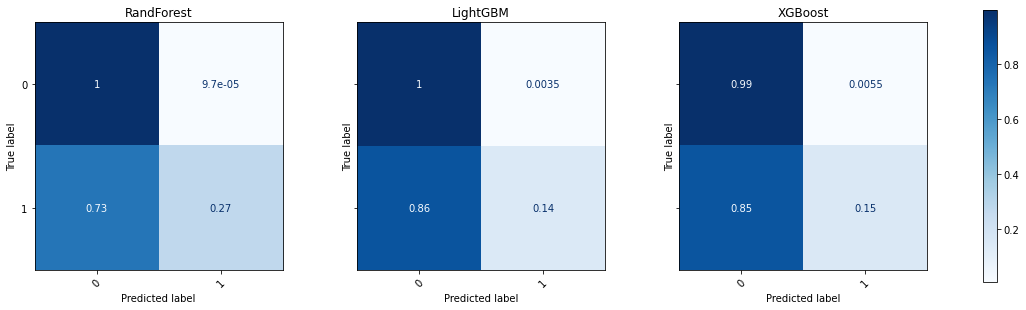

In [72]:
# plot das matrizes de confusão
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharey='row')

i = 0
for model_name, model in trained_models.items():
    disp = ConfusionMatrixDisplay(confusion_matrix(y_train, model.predict(X_train), normalize='true'), display_labels=[0, 1])
    disp.plot(ax=axes[i], xticks_rotation=45, cmap='Blues')
    disp.ax_.set_title(model_name)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('Predicted label')
    disp.ax_.set_ylabel('True label')
    i += 1

plt.subplots_adjust(wspace=.3, hspace=.1)

f.colorbar(disp.im_, ax=axes)
plt.show()

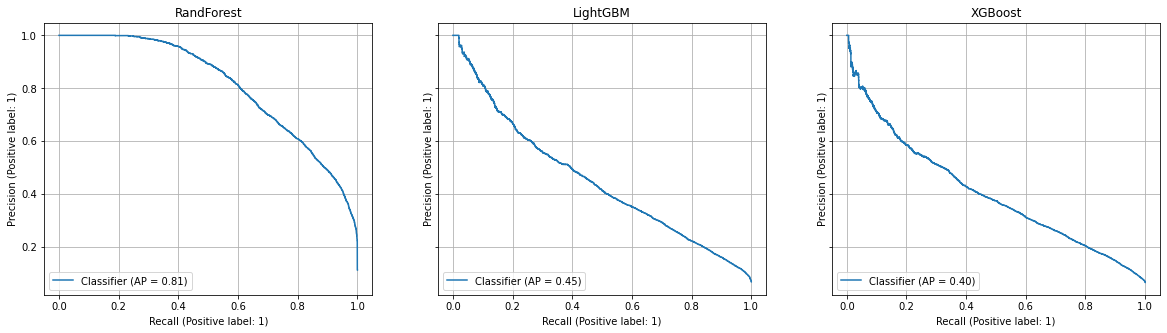

In [73]:
# plot das curvas de recall-precision
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharey='row')

i = 0
for model_name, model in trained_models.items():
    disp = PrecisionRecallDisplay.from_predictions(y_train, model.predict_proba(X_train)[:,1], ax=axes[i])
    disp.ax_.set_title(model_name)
    axes[i].grid()
    i += 1

plt.show()

O modelo que se mostrou com melhor curva de precision-recall foi o Random Forest, portanto seguiremos com ele para a etapa final

---
## Seguindo com _Random Forest_ para etapa final

Ajustando os Thresholds

---

In [74]:
# listas com as precisions, recalls e thresholds para vários pontos da curva (pega apenas a coluna 1 do resultado da função -> probabilidades para classe 1)
precision, recall, threshold = precision_recall_curve(y_train, rf_gs.predict_proba(X_train)[:,1])
# adiciona um NaN apenas para que fique do mesmo tamanho que as outras listas
threshold = np.append(threshold, np.nan)

In [100]:
""" analisando os dados acima em um dataframe e pegando os threshold que geram no mínimo
um recall de 80% (valores podem ser alterados de acordo com a "necessidade de mais acerto" do modelo)"""
rf_prc = pd.DataFrame({'Precision': precision.T, 
                        'Recall': recall.T, 
                        'Threshold': threshold.T
                        }).query('Recall >= .8')
rf_prc

,Precision,Recall,Threshold
0,0.113550,1.000000,0.015320
1,0.113530,0.999805,0.015321
2,0.113533,0.999805,0.015322
3,0.113535,0.999805,0.015323
4,0.113538,0.999805,0.015324
...,...,...,...
38453,0.609470,0.800078,0.201869
38454,0.609561,0.800078,0.201891
38455,0.609651,0.800078,0.201924
38456,0.609742,0.800078,0.201943


In [101]:
final_model_rf = rf_gs.best_estimator_

In [102]:
rf_ajustado = Thresholder(final_model_rf, 0.201973) # Threshold com Precision de 51.87% e Recall de 80%
rf_ajustado.fit(X_train, y_train)

Thresholder(model=RandomForestClassifier(criterion='entropy',
                                         max_depth=14.385527090157503,
                                         max_features='log2', n_jobs=-1,
                                         random_state=42),
            threshold=0.201973)

X has feature names, but RandomForestClassifier was fitted without feature names


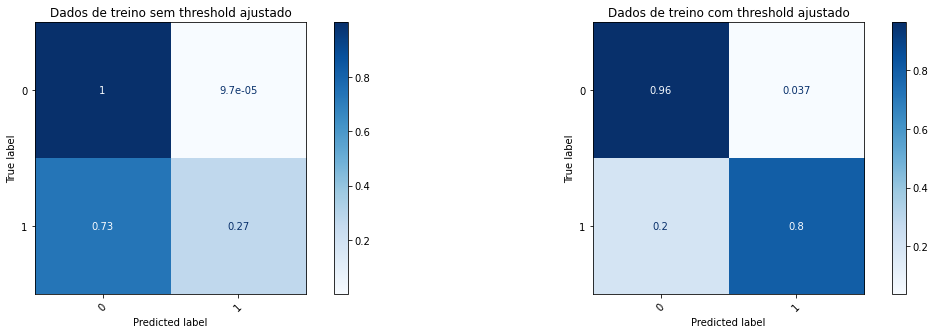

In [103]:
# plot matriz confusão - dados de treino
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

disp11 = ConfusionMatrixDisplay(confusion_matrix(y_train, rf_gs.predict(X_train), normalize='true'), display_labels=[0, 1])
disp11.plot(ax=ax[0], xticks_rotation=45, cmap='Blues')
disp11.ax_.set_title('Dados de treino sem threshold ajustado')
disp12 = ConfusionMatrixDisplay(confusion_matrix(y_train, rf_ajustado.predict(X_train), normalize='true'), display_labels=[0, 1])
disp12.plot(ax=ax[1], xticks_rotation=45, cmap='Blues')
disp12.ax_.set_title('Dados de treino com threshold ajustado')
plt.subplots_adjust(wspace=0)

plt.show()

O modelo final terá o threshold ajustado.

___
## Testando do modelo
---

X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


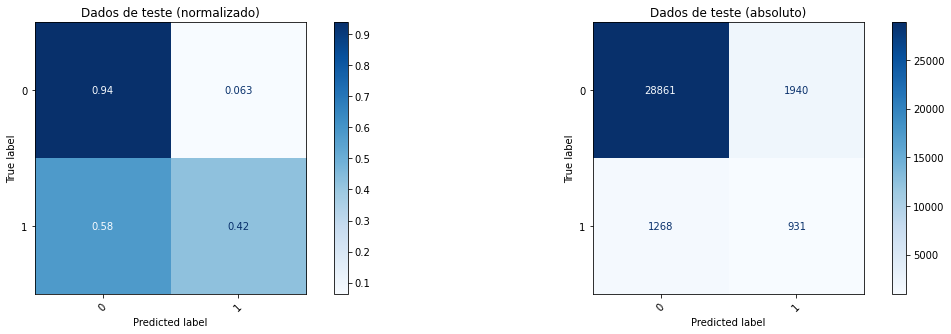

In [104]:
# plot da matriz de confusão para os dados de teste: dados nunca antes vistos pelo modelo e que representariam os dados reais utilizados para
# classificar os clientes em ad/inadimplentes
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

disp11 = ConfusionMatrixDisplay(confusion_matrix(y_test, rf_ajustado.predict(X_test), normalize='true'), display_labels=[0, 1])
disp11.plot(ax=ax[0], xticks_rotation=45, cmap='Blues')
disp11.ax_.set_title('Dados de teste (normalizado)')
disp12 = ConfusionMatrixDisplay(confusion_matrix(y_test, rf_ajustado.predict(X_test)), display_labels=[0, 1])
disp12.plot(ax=ax[1], xticks_rotation=45, cmap='Blues')
disp12.ax_.set_title('Dados de teste (absoluto)')
plt.subplots_adjust(wspace=0)

plt.show()

In [105]:
# Exportando o modelo em Pickle
# Descomentar as 3 linhas abaixo para salvar o modelo:

# output = open('modelo_rf', 'wb')
# pickle.dump(rf_ajustado, output)
# output.close()

---
## Validando o modelo
---

In [81]:
X_val = data_val

Criando a coluna `inadimplente` no dataset `teste.csv`, que foi chamado de `data_val` nesta análise.

In [82]:
data_val.insert(1, 'inadimplente', rf_ajustado.predict(X_val))

X has feature names, but RandomForestClassifier was fitted without feature names


In [83]:
data_val

,cliente,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_emprestimos_imobiliarios,numero_de_dependentes
0,1,0,0.025849,62,0,0.081775,8180.0,3,2,0.0
1,2,0,0.667083,55,0,0.153112,2200.0,3,0,0.0
2,3,0,0.007093,44,0,0.148800,7499.0,20,1,0.0
3,4,0,0.091213,54,0,0.351635,5900.0,15,1,0.0
4,5,0,0.112680,54,0,0.065959,2167.0,3,0,0.0
...,...,...,...,...,...,...,...,...,...,...
39995,39996,0,0.000000,68,1,0.062858,10833.0,9,0,0.0
39996,39997,0,0.061117,84,0,0.013598,8456.0,7,0,0.0
39997,39998,0,0.817745,70,0,0.663056,6000.0,17,2,0.0
39998,39999,0,0.106139,64,2,0.865438,5045.0,12,4,0.0


In [84]:
data_val['inadimplente'].value_counts()

0    36500
1     3500
Name: inadimplente, dtype: int64

In [85]:
# print de informações
qtd_total_val = data_val.shape[0]
inadimplentes_val = sum(data_val['inadimplente'])
adimplentes_val = qtd_total_val - inadimplentes_val

print("Teste:")
print(f"{inadimplentes_val} usuarios possivelmente inadimplentes -> {inadimplentes_val/qtd_total_val * 100:3.2f}% dos dados totais")
print(f"{adimplentes_val} usuarios possivelmente adimplentes -> {adimplentes_val/qtd_total_val * 100:3.2f}% dos dados totais\n")

Teste:
3500 usuarios possivelmente inadimplentes -> 8.75% dos dados totais
36500 usuarios possivelmente adimplentes -> 91.25% dos dados totais



In [86]:
data_val.to_csv('../case_datarisk/predito.csv', index=False)